In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop

from algos import deep_fib

from common import metrics
from common.models import resnet
from common.models import deeplab
from common.models import modutils

In [3]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.01, random_state=42)


In [4]:
# m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.MINMAX)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.MINMAX)


Loading: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


In [75]:
horizon = 1024
stride = 512
n_masks = 25

batch_size = 32

log_dir = "./trained/deep_fib"
loss_type = "mse"
lr = 1e-3
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [6]:
# dataset_train = data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
dataset_test = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

# masks = deep_fib.get_masks(horizon, n_masks).float()

# print(len(dataset_train), len(dataset_test), masks.size())


In [7]:
# train_loader = DataLoader(
#     dataset_train,
#     batch_size,
#     shuffle=True,
# )
test_loader = DataLoader(
    dataset_test,
    batch_size,
    shuffle=False,
)
# print(len(train_loader), len(test_loader))


In [8]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
).float()

# optim = Adam(model.parameters(), lr=lr)
# lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = deep_fib.DeepFIBEngine(
    model=model,
    device=device,
    # optimizer=optim,
    # lr_scheduler=lr_sched,
    # masks=masks,
    # loss_type=loss_type,
)

In [9]:
# with SummaryWriter(log_dir) as writer:
#     training_loop(
#         engine=engine,
#         num_epochs=num_epochs,
#         train_dataloader=train_loader,
#         test_dataloader=test_loader,
#         writer=writer,
#         save_path=log_dir + "/models",
#     )


In [20]:

modutils.load_model(model, "outputs/deep_fib_deeplab_sigmoid/models/model_29.pth", device)
print(model._get_name())

DeepLabNet


In [12]:
from tqdm import tqdm

def get_predictions():
    all_errors_ = []
    all_labels_ = []

    for batch in tqdm(test_loader):
        errors = engine.predict(batch["data"])
        all_errors_.append(errors.cpu())
        all_labels_.append(batch["label"])

    all_errors = torch.concat(all_errors_)
    all_labels = torch.concat(all_labels_)

    return all_errors, all_labels

all_errors, all_labels = get_predictions()

100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


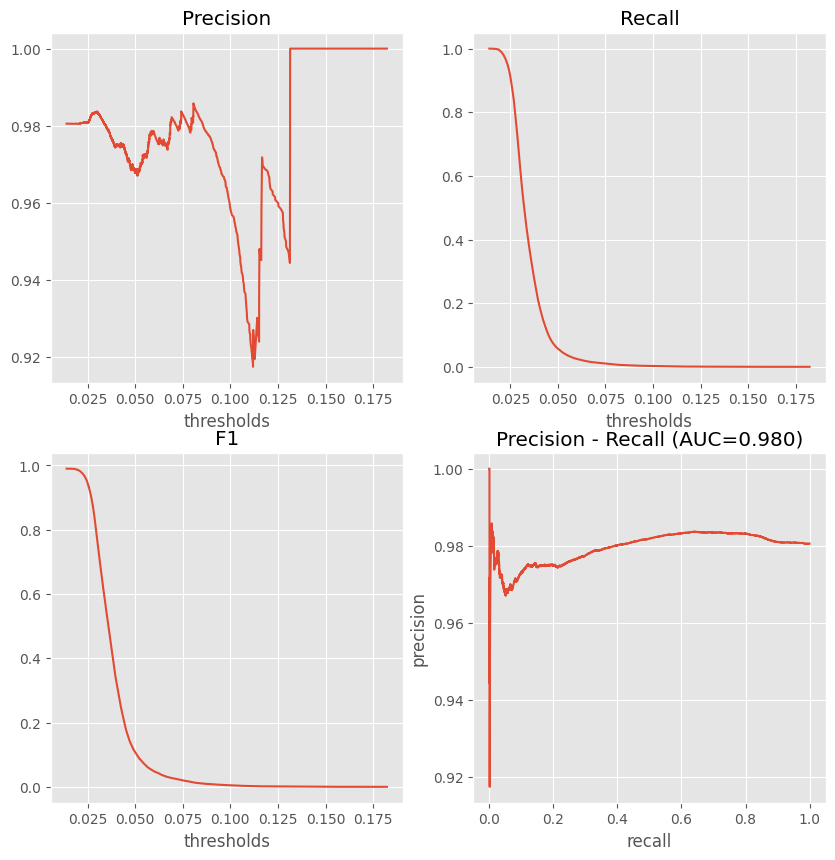

In [13]:
metrics.plot_precision_recall_curve(all_errors, all_labels)

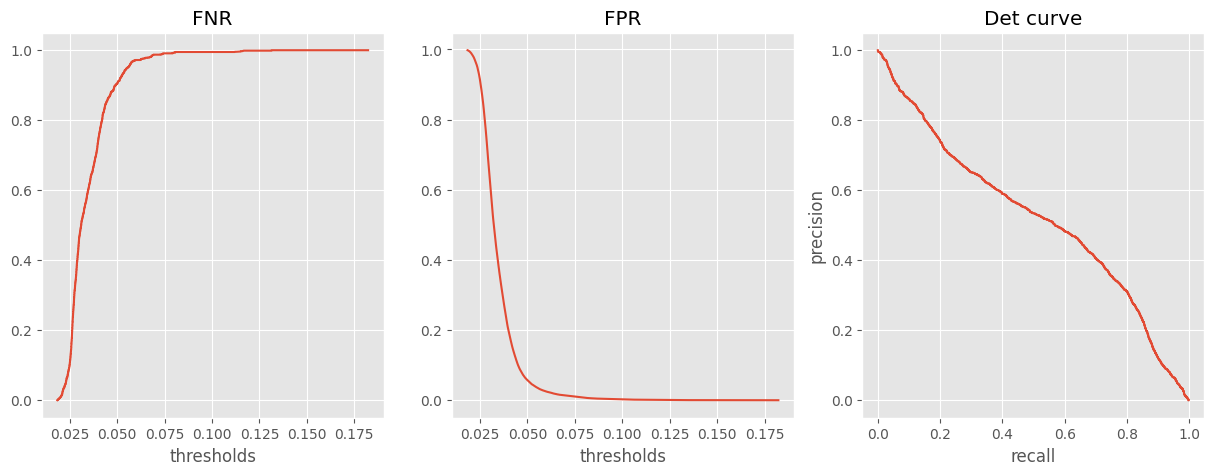

In [24]:
metrics.plot_det_curve(all_errors, all_labels, figsize=(15, 5))

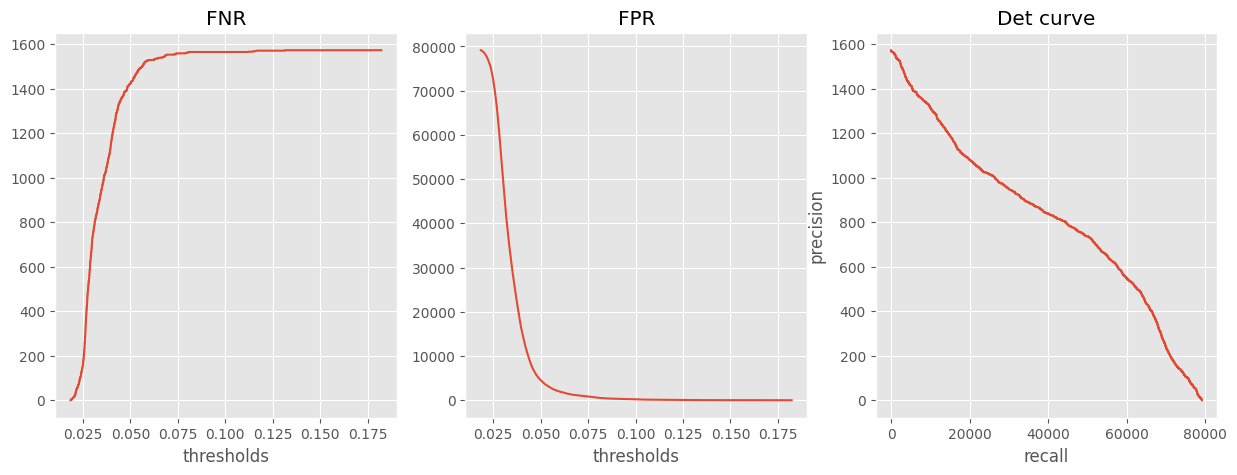

In [25]:
metrics.plot_errors_curve(all_errors, all_labels, figsize=(15, 5))

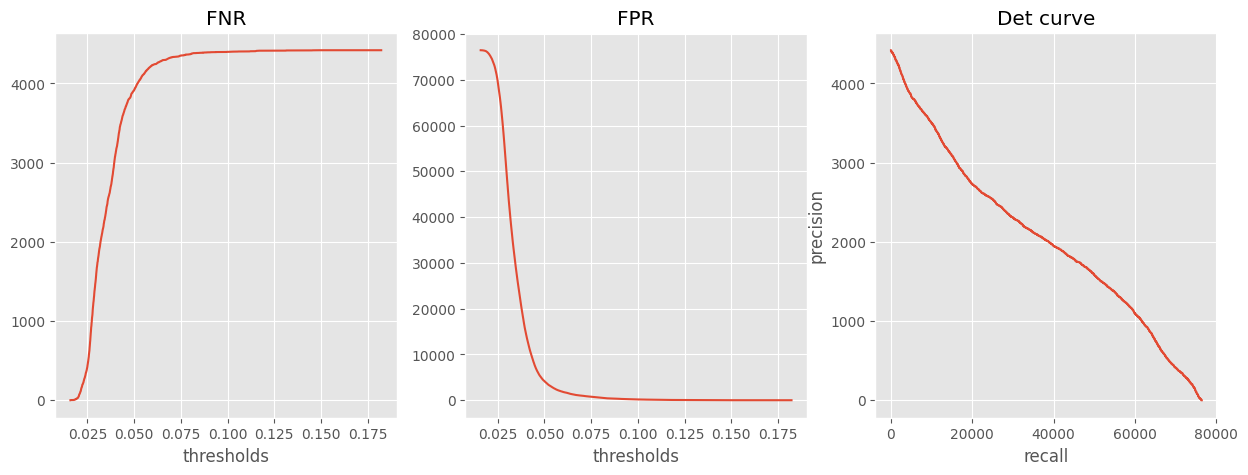

In [61]:
metrics.plot_errors_curve(all_errors, all_labels, 12, figsize=(15, 5))

In [72]:
i = 50
j = 974

red_err = all_errors[i:i+3, j:j+10]
red_lab = all_labels[i:i+3, j:j+10]

red_lab

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)

In [74]:
def s():
    for i in range(all_errors.size(0) - 3):
        for j in range(all_errors.size(1) - 10):
            red_err = all_errors[i:i+3, j:j+10]
            red_lab = all_labels[i:i+3, j:j+10]

            if all(red_lab.sum(1) > 0):
                print(i, j)
                return
s()

In [ ]:
metrics.plot_errors_curve(all_errors, all_labels, 12, figsize=(15, 5))

In [ ]:
# Cost model
c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  metrics.HPCMetrics(c_alarm, c_missed, tolerance)

In [33]:
all_labels.shape

torch.Size([79, 1024])

In [89]:
import torch.nn.functional as F

def cm_win(winsize: int):
    labels = torch.tensor([
        [0, 0, 0, 1, 0, 0, 0], 
        [0, 1, 0, 0, 0, 0, 0], 
        [0, 1, 1, 0, 0, 0, 0]
    ])
    print(labels, labels.size())
    labels = labels.flatten()

    gt_labels = torch.tensor([
        [0, 0, 0, 0, 1, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0], 
        [0, 1, 0, 0, 0, 0, 0]
    ])
    print(gt_labels, gt_labels.size())
    
    print(metrics._skm.confusion_matrix(gt_labels.flatten(), labels))

    indexes = (gt_labels == 1).nonzero()
    print(indexes, indexes.size())

    gt_w = gt_labels.clone()
    for x, y in indexes:
        for i in range(-winsize, winsize+1):
            if 0 <= y+i < gt_labels.size(1):
                gt_w[x, y+i] = 1
    print(gt_w, gt_w.size())

    print(metrics._skm.confusion_matrix(gt_w.flatten(), labels))
    print(metrics._skm.confusion_matrix(1 - gt_w.flatten(), 1 - labels))


cm_win(2)

tensor([[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0]]) torch.Size([3, 7])
tensor([[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0]]) torch.Size([3, 7])
[[15  3]
 [ 2  1]]
tensor([[0, 4],
        [1, 5],
        [2, 1]]) torch.Size([3, 2])
tensor([[0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0]]) torch.Size([3, 7])
[[ 7  1]
 [10  3]]
[[ 3 10]
 [ 1  7]]


In [108]:
def errors_curve_orig(
    signals, labels
):
    labels = labels.cpu().flatten()
    signals = signals.cpu().flatten()

    fp, fn, th = metrics._fp_fn_curve(labels, signals, pos_label=0)

    _, axes = metrics.plt.subplots(1, 3)  # type: ignore
    fn_ax, fp_ax, c_ax = axes
    fn_ax.set_title("False Negatives")
    fn_ax.plot(th, fn)
    fn_ax.set_xlabel("thresholds")

    fp_ax.set_title("False Positives")
    fp_ax.plot(th, fp)
    fp_ax.set_xlabel("thresholds")

    c_ax.set_title(f"Det curve")
    c_ax.plot(fp, fn)
    c_ax.set_ylabel("precision")
    c_ax.set_xlabel("recall")
    metrics.plt.show()

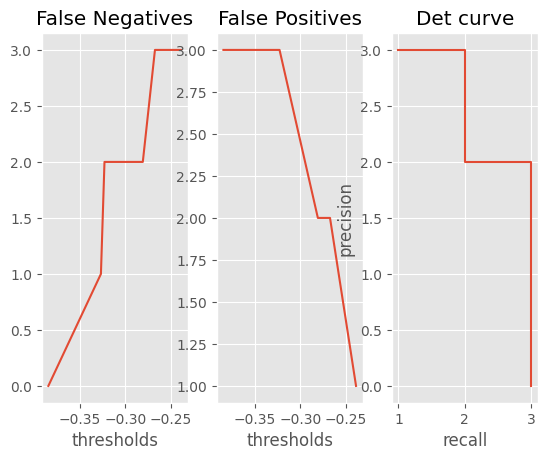

tensor([[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0]])
tensor([[-0.0130,  0.0331,  0.2395,  0.8796, -0.2673, -0.0295,  0.4233],
        [-0.3851,  0.8297,  0.4683, -0.2807, -0.2168, -0.3230,  0.1362],
        [ 0.4368,  0.9331,  0.9230, -0.3270, -0.2385,  0.2333, -0.1113]],
       dtype=torch.float64)
tensor([[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0]])


ValueError: x and y must have same first dimension, but have shapes (19,) and (21,)

In [119]:
import torch.nn.functional as F

def cm_win(winsize: int):
    labels = torch.tensor([
        [0, 0, 0, 1, 0, 0, 0], 
        [0, 1, 0, 0, 0, 0, 0], 
        [0, 1, 1, 0, 0, 0, 0]
    ], dtype=float)
    signals = labels - torch.empty(labels.size()).uniform_(-0.5, 0.5)
    gt_labels = torch.tensor([
        [0, 0, 0, 0, 1, 0, 0], 
        [0, 0, 0, 0, 0, 1, 0], 
        [0, 1, 0, 0, 0, 0, 0]
    ])

    errors_curve_orig(signals, gt_labels)
    print(gt_labels)
    print(signals)
    print((signals > 0.5).to(int))
    metrics.plot_errors_curve(signals, gt_labels, 0)
    print(gt_labels)
    print(signals)
    print((signals > 0.5).to(int))
    metrics.plot_errors_curve(signals, gt_labels, winsize)

cm_win(2)